In [1]:
import pickle
from sklearn import manifold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data1 = pickle.load(open('./data/outputs_lumo_model.pkl', 'rb'))
data2 = pickle.load(open('./data/outputs_TL_homo_lumo_model.pkl', 'rb'))
data3 = pickle.load(open('./data/outputs_TLF_homo_lumo_model.pkl', 'rb'))

# data = [data1, data2, data3]
data = [data1, data2]

In [3]:
print(data1[3130]["embeddings"])
print(data2[3130]["embeddings"])

[[ 1.04965556e+00 -3.87304693e-01 -6.82320222e-02 -1.09606087e+00
  -1.17759597e+00 -3.67856443e-01 -5.37873864e-01  4.44083631e-01
   5.61745107e-01  4.12851721e-02 -3.31202596e-01  8.91689956e-01
  -4.49880734e-02  2.87915528e-01  1.94652402e+00  1.14830816e+00
  -8.33008409e-01  3.64733249e-01  7.21084177e-01 -6.92539215e-01
   9.91429746e-01  7.14188755e-01  1.58292025e-01  2.04838800e+00
   1.78720802e-01 -6.50851429e-01 -1.24209023e+00  2.23712638e-01
   4.20743108e-01  6.77522600e-01 -2.82931924e-02  1.45130128e-01]
 [ 1.41837311e+00 -2.50107676e-01  2.47139290e-01 -1.28174579e+00
  -1.38412428e+00 -3.70326966e-01 -8.43616605e-01 -4.85545576e-01
   1.13246250e+00  2.48892099e-01  5.54569811e-02  8.14549446e-01
   9.20632631e-02 -4.04846035e-02  1.00918090e+00  9.13771749e-01
  -1.99853301e-01  8.47346365e-01  6.90128058e-02 -7.87766635e-01
   1.01300740e+00 -2.97884762e-01  4.99712616e-01  2.02970934e+00
   2.02408224e-01 -1.01397383e+00 -9.23646748e-01 -1.77425593e-01
   4.6812

In [3]:
H = 1
C = 6
N = 7
O = 8

embeddings = []

for d in data:
    dataset_embeddings = []
    for molecule in d:
        for idx in range(len(molecule["atom_numbers"])):
            if molecule["atom_numbers"][idx] == N:
                embd = molecule["embeddings"][idx]
                dataset_embeddings.append(embd)

    embeddings.append(dataset_embeddings)

In [4]:
data = np.array([embeddings])
data = data.squeeze()

In [6]:
print(data[0].shape)

(10370, 32)


In [5]:
tsne_results_x = []
tsne_results_y = []
source_labels = []

i = 0
for d in data:
    tsne = manifold.TSNE(n_components=2, random_state=42, n_iter=1000, perplexity=50, learning_rate='auto')
    tsne_result = tsne.fit_transform(d)
    tsne_results_x.append(tsne_result[:, 0])
    tsne_results_y.append(tsne_result[:, 1])
    source_labels.append(np.ones(len(tsne_result[:, 0]))*i)
    i += 1


In [6]:
x = np.array(tsne_results_x).reshape(-1)
y = np.array(tsne_results_y).reshape(-1)
labels = np.array(source_labels).reshape(-1)


In [14]:
print(tsne_results_x[0].shape)

(10370,)


Average distance between same points in different sources: 23.546990336505168
Average distance between different points in different sources: 35.61902658321352


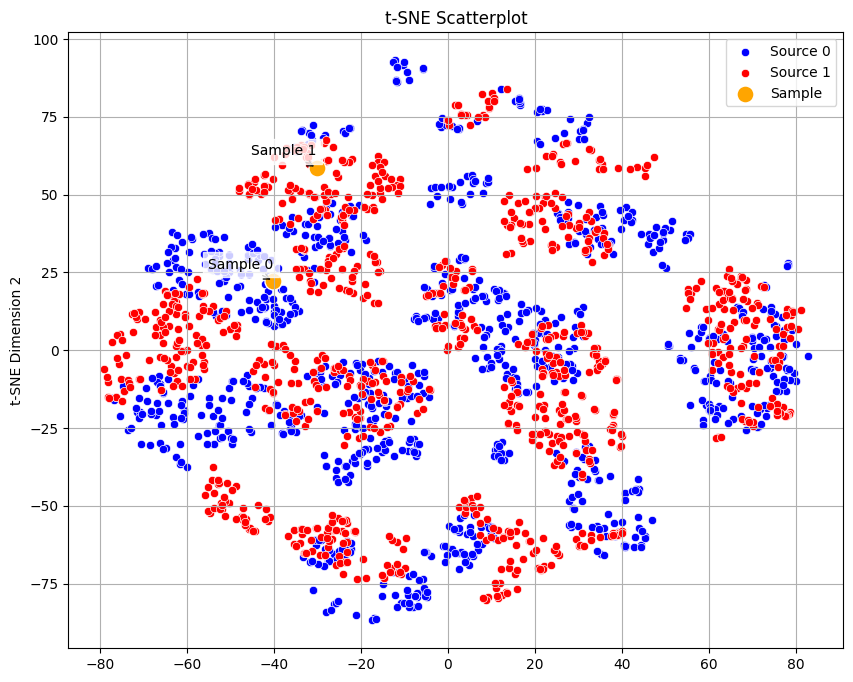

In [53]:
import random
from typing import Tuple, List
import seaborn as sns

random.seed(42)

def pairwise_distance(p1: Tuple[float, float], p2: Tuple[float, float]) -> float:
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def abs_mean(distances: List[float]) -> float:
    return np.mean(np.abs(distances))

def sample_ranges(indicies: List[int]):
    ranges = []
    for idx in indicies:
        choice = idx
        while choice == idx:
            choice = random.choice(indicies)
            
        ranges.append((idx, choice))
    return ranges

sample_idx = random.sample(range(len(tsne_results_x[0])-15), 1000)
idx_ranges = sample_ranges(sample_idx)

distances1 = []
distances2 = []

for (idx1, idx2) in idx_ranges:
    p1_1 = (tsne_results_x[0][idx1], tsne_results_y[0][idx1])
    p2_1 = (tsne_results_x[0][idx2], tsne_results_y[0][idx2])
    dist1 = pairwise_distance(p1_1, p2_1)

    p1_2 = (tsne_results_x[1][idx1], tsne_results_y[1][idx1])
    p2_2 = (tsne_results_x[1][idx2], tsne_results_y[1][idx2])
    dist2 = pairwise_distance(p1_2, p2_2)

    p1_uncor = (tsne_results_x[0][idx1+15], tsne_results_y[0][idx1+15])
    p2_uncor = (tsne_results_x[0][idx2], tsne_results_y[0][idx2])
    dist_uncor = pairwise_distance(p1_uncor, p2_uncor)

    distances1.append(dist1-dist2)
    distances2.append(dist1-dist_uncor)

avg_dist_pd = abs_mean(distances1)
avg_dist_upd = abs_mean(distances2)

print(f"Average distance between same points in different sources: {avg_dist_pd}")
print(f"Average distance between different points in different sources: {avg_dist_upd}")

SAMPLE_IDX = 500
sample_x = [tsne_results_x[0][SAMPLE_IDX], tsne_results_x[1][SAMPLE_IDX]*-1]
sample_y = [tsne_results_y[0][SAMPLE_IDX], tsne_results_y[1][SAMPLE_IDX]]

plt.figure(figsize=(10, 8))
plt.grid(True)  # Add gridlines
sns.scatterplot(x=tsne_results_x[0][sample_idx], y=tsne_results_y[0][sample_idx], color='blue', label='Source 0')
sns.scatterplot(x=tsne_results_x[1][sample_idx]*(-1), y=tsne_results_y[1][sample_idx], color='red', label='Source 1')
sns.scatterplot(x=sample_x, y=sample_y, color='orange', label='Sample', s=150)
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.title('t-SNE Scatterplot')

# Add text next to the sampled points
for i, (x, y) in enumerate(zip(sample_x, sample_y)):
    plt.text(x - 15, y + 4, f'Sample {i}', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    plt.annotate(f'Sample {i}', (x, y), xytext=(x - 15, y + 4), arrowprops=dict(arrowstyle='->'))

plt.show()


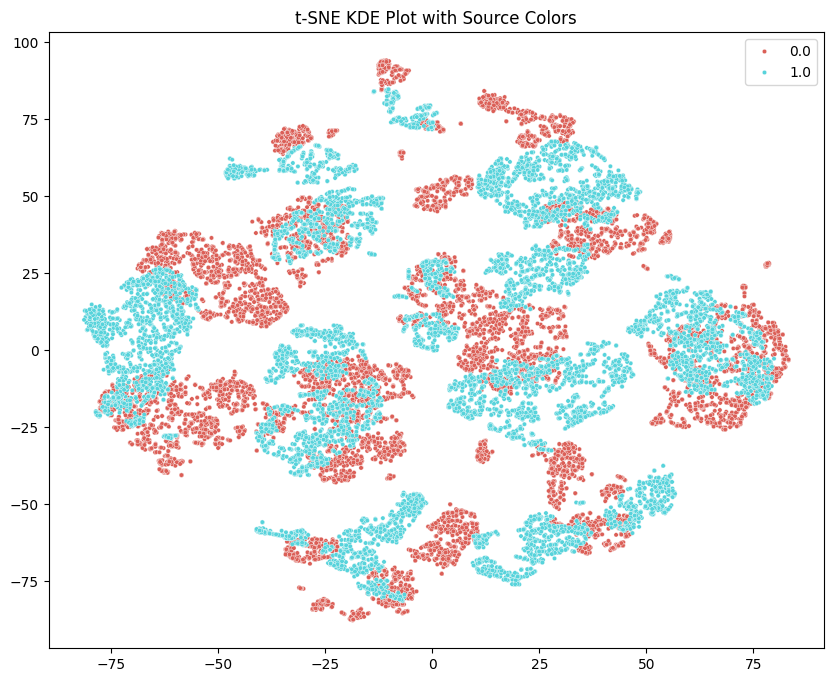

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [23]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=x,
    y=y,
    hue=labels,
    alpha=1,
    palette=sns.color_palette("hls", len(data)),
    s=10,
    legend="full"
)
plt.title('t-SNE KDE Plot with Source Colors')
plt.show()


/home/aimas/dtu/dl/DeepLearningProject/.venv/lib/python3.10/site-packages/seaborn/utils.py:128: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scout = method(scout_x, scout_y, **kws)
/home/aimas/dtu/dl/DeepLearningProject/.venv/lib/python3.10/site-packages/seaborn/relational.py:432: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


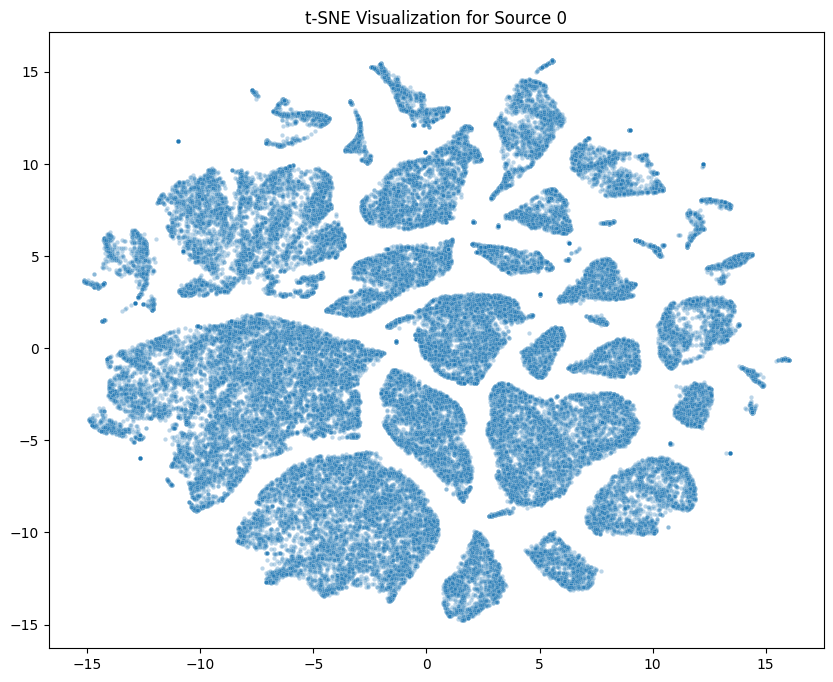

/home/aimas/dtu/dl/DeepLearningProject/.venv/lib/python3.10/site-packages/seaborn/utils.py:128: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scout = method(scout_x, scout_y, **kws)
/home/aimas/dtu/dl/DeepLearningProject/.venv/lib/python3.10/site-packages/seaborn/relational.py:432: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


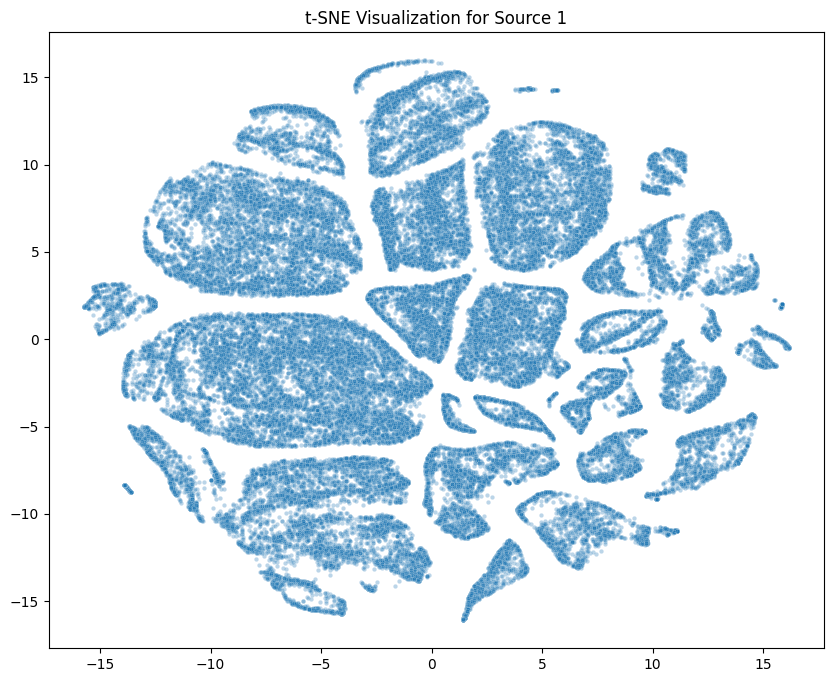

/home/aimas/dtu/dl/DeepLearningProject/.venv/lib/python3.10/site-packages/seaborn/utils.py:128: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scout = method(scout_x, scout_y, **kws)
/home/aimas/dtu/dl/DeepLearningProject/.venv/lib/python3.10/site-packages/seaborn/relational.py:432: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


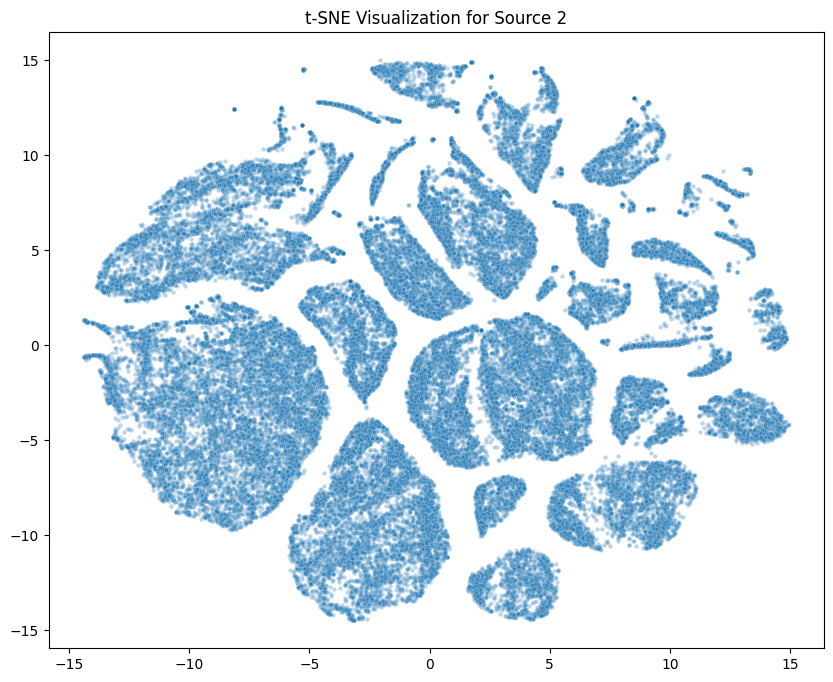

In [27]:
for idx in range(len(data)):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=tsne_results_x[idx], 
                    y=tsne_results_y[idx], 
                    alpha=0.3, 
                    cmap="magma",
                    s=10,
                    )
    plt.title('t-SNE Visualization for Source {}'.format(idx))
    plt.show()